In [1]:
!pip install 'git+https://github.com/dhritimandas/nobrainer.git'

  Cloning https://github.com/dhritimandas/nobrainer.git to /tmp/pip-req-build-i59y4elq
  Running command git clone -q https://github.com/dhritimandas/nobrainer.git /tmp/pip-req-build-i59y4elq
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for nobrainer: filename=nobrainer-0.1a24-py3-none-any.whl size=89402 sha256=819435f6e625b992c8aae2f687873814734e9b80b9ff9220f904301491d03f1f
  Stored in directory: /tmp/pip-ephem-wheel-cache-nhyynwtw/wheels/a2/2d/c7/2659e0b9d7f614f0dd3882e3e0169bee98f09cfd96aca92f0f
Successfully built nobrainer


In [2]:
!pip install --no-cache-dir nilearn nibabel

     |████████████████████████████████| 4.9 MB 4.1 MB/s 


In [3]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [4]:
import os
import glob
import datetime
from time import time

import numpy as np
import pandas as pd

import nobrainer
import tensorflow as tf
from tensorflow.keras import layers, regularizers, activations

import matplotlib.pyplot as plt
from nibabel import processing
from nilearn import plotting

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


# Downloading Data
Assign random classification labels


---



---



In [5]:
import random

csv_of_filepaths = nobrainer.utils.get_data()
filepaths = nobrainer.io.read_csv(csv_of_filepaths)

# Add random boolean values
filepaths = [(x, random.choice([0, 1])) for x, _ in filepaths]

335872/335557 [==============================] - 1s 2us/step


In [6]:
filepaths

[('/tmp/nobrainer-data/datasets/sub-01_t1.mgz', 1),
 ('/tmp/nobrainer-data/datasets/sub-02_t1.mgz', 0),
 ('/tmp/nobrainer-data/datasets/sub-03_t1.mgz', 0),
 ('/tmp/nobrainer-data/datasets/sub-04_t1.mgz', 0),
 ('/tmp/nobrainer-data/datasets/sub-05_t1.mgz', 1),
 ('/tmp/nobrainer-data/datasets/sub-06_t1.mgz', 0),
 ('/tmp/nobrainer-data/datasets/sub-07_t1.mgz', 0),
 ('/tmp/nobrainer-data/datasets/sub-08_t1.mgz', 1),
 ('/tmp/nobrainer-data/datasets/sub-09_t1.mgz', 0),
 ('/tmp/nobrainer-data/datasets/sub-10_t1.mgz', 1)]

# Define dataset for pretrain, train and evaluation

Assign 6 volumes for unsupervised training, 3 volumes for supervised-training and 1 volume for evaluation

In [7]:
train_paths = filepaths[:9]
evaluate_paths = filepaths[9:]

Verify that all volumes have the same shape and that labels are integer-ish.

In [8]:

invalid = nobrainer.io.verify_features_labels(train_paths)
assert not invalid

invalid = nobrainer.io.verify_features_labels(evaluate_paths)
assert not invalid

Verifying 9 examples
9/9 [==============================] - 0s 11ms/step
Verifying 1 examples
1/1 [==============================] - 0s 105ms/step


In [9]:
!mkdir -p data

Convert pre-training, training and evaluation data to TFRecords.


In [10]:
nobrainer.tfrecord.write(
    features_labels=train_paths,
    filename_template='data/data-train_shard-{shard:03d}.tfrec',
    examples_per_shard=3)

nobrainer.tfrecord.write(
    features_labels=evaluate_paths,
    filename_template='data/data-evaluate_shard-{shard:03d}.tfrec',
    examples_per_shard=1)

1/1 [==============================] - 3s 3s/step


In [11]:
!ls data

data-evaluate_shard-000.tfrec  data-train_shard-001.tfrec
data-train_shard-000.tfrec     data-train_shard-002.tfrec


Define model and dataset parameters

In [12]:
n_classes = 1
batch_size = 2
volume_shape = (256, 256, 256)
block_shape = (64, 64, 64)
n_epochs = None
num_parallel_calls = 2

# Create augmented dataset. 

For demonstration purposes, we add only Gaussian Noise and Random Rigid Transforms

Augment type: Gaussian Noise; 

*set Augment= True, AugmentType=True*

In [13]:
augment_noise = nobrainer.dataset.get_dataset(
    file_pattern="data/data-train_shard*.tfrec",
    n_classes=n_classes,
    batch_size=batch_size,
    volume_shape=volume_shape,
    scalar_label=True,
    augment=True,
    augmentType=True,
    block_shape=block_shape,
    n_epochs=n_epochs,
    num_parallel_calls=num_parallel_calls,
)

scalar true
augment type: true, add Gaussian Noise


Augment rigid transforms: Rigid Transforms; 

*set Augment= True, AugmentType=False*

In [14]:
augment_rigid_tfm = nobrainer.dataset.get_dataset(
    file_pattern="data/data-train_shard*.tfrec",
    n_classes=n_classes,
    batch_size=batch_size,
    volume_shape=volume_shape,
    scalar_label=True,
    augment=True,
    augmentType=False,
    block_shape=block_shape,
    n_epochs=n_epochs,
    num_parallel_calls=num_parallel_calls,
)

scalar true
augment type: false, add random transform
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Another set where we do NOT apply any augmentations

*set Augment= False, do **not** give AugmentType option*



In [15]:
augment_none = nobrainer.dataset.get_dataset(
    file_pattern="data/data-train_shard*.tfrec",
    n_classes=n_classes,
    batch_size=batch_size,
    volume_shape=volume_shape,
    scalar_label=True,
    augment=False,
    block_shape=block_shape,
    n_epochs=n_epochs,
    num_parallel_calls=num_parallel_calls,
)

# Now define the evaluation dataset

evaluate None; set Augment= False

In [16]:
evaluate_none = nobrainer.dataset.get_dataset(
    file_pattern="data/data-evaluate_shard*.tfrec",
    n_classes=n_classes,
    batch_size=batch_size,
    volume_shape=volume_shape,
    scalar_label=True,
    augment=False,
    block_shape=block_shape,
    n_epochs=n_epochs,
    num_parallel_calls=num_parallel_calls,
)

In [17]:
print("supervised data noise: ",augment_noise)
print("supervised data rigid: ",augment_rigid_tfm)
print("supervised data none: ",augment_none)
print("dataset_evaluate: ",evaluate_none)


supervised data noise:  <RepeatDataset shapes: ((2, 64, 64, 64, 1), (2,)), types: (tf.float32, tf.float32)>
supervised data rigid:  <RepeatDataset shapes: ((2, 64, 64, 64, 1), (2,)), types: (tf.float32, tf.float32)>
supervised data none:  <RepeatDataset shapes: ((2, 64, 64, 64, 1), (2,)), types: (tf.float32, tf.float32)>
dataset_evaluate:  <RepeatDataset shapes: ((2, 64, 64, 64, 1), (2,)), types: (tf.float32, tf.float32)>


## create unsupervised datasets by removing labels

In [18]:
unsupv_augment_noise = augment_noise.map(lambda x, y:x)
unsupv_augment_rigid_tfm = augment_rigid_tfm.map(lambda x, y:x)
unsupv_augment_none = augment_none.map(lambda x, y:x)


In [19]:
print("unsupervised data noise ",unsupv_augment_noise)
print("unsupervised data rigid ",unsupv_augment_rigid_tfm)
print("unsupervised data none ",unsupv_augment_none)

unsupervised data noise  <MapDataset shapes: (2, 64, 64, 64, 1), types: tf.float32>
unsupervised data rigid  <MapDataset shapes: (2, 64, 64, 64, 1), types: tf.float32>
unsupervised data none  <MapDataset shapes: (2, 64, 64, 64, 1), types: tf.float32>


# zip augmented datasets to create a training pair (noise, rigid transforms)

In [20]:
unsupv_augment_noise_rigid = tf.data.Dataset.zip((unsupv_augment_noise, unsupv_augment_rigid_tfm))

unsupv_augment_noise_rigid

<ZipDataset shapes: ((2, 64, 64, 64, 1), (2, 64, 64, 64, 1)), types: (tf.float32, tf.float32)>

In [66]:
steps = nobrainer.dataset.get_steps_per_epoch(
    n_volumes = len(train_paths),
    volume_shape=volume_shape,
    block_shape=block_shape,
    batch_size=batch_size
)

steps = 62 #using len(train_paths) gives 288 steps which overfits 

Define SimSiam parameters

In [67]:
 weight_decay = 0.0005
 projection_dim = 4096 #Depending on the dataset, increasing the projection dim may also help* 
 latent_dim = 512


Define and instantiate the **encoder and predictor** for the simsiam architecture

In [68]:
from nobrainer.models.simsiam_brain import simsiam_brain
from nobrainer import simsiam_brain_trainer

In [69]:
encoder, predictor = simsiam_brain(n_classes=n_classes, input_shape=(*block_shape, 1),weight_decay = weight_decay,
    projection_dim = projection_dim,
    latent_dim = latent_dim,
    )

projection dimension is:  4096
latent dimension:  512
may not show both encoder and predictor architecture summary due to lack of space....


In [70]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 64, 64, 64, 1)]   0         
_________________________________________________________________
highresnet (Functional)      (None, 64, 64, 64, 1)     874785    
_________________________________________________________________
backbone_pool (GlobalAverage (None, 1)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 4096)              4096      
_________________________________________________________________
batch_normalization_81 (Batc (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 4096)              1677

In [71]:
predictor.summary()

Model: "predictor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               2097152   
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_83 (Batc (None, 512)               2048      
_________________________________________________________________
dense_15 (Dense)             (None, 4096)              2101248   
Total params: 4,200,448
Trainable params: 4,199,424
Non-trainable params: 1,024
_________________________________________________________________


# Define learning rate (cosine decayed function)

In [72]:
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.0005, decay_steps=steps #original initial rate as per paper = 0.001
)

# Define early stopping callback

In [73]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=5, restore_best_weights=True
)

# Define training and compile

In [74]:
epochs=10

In [75]:
model = simsiam_brain_trainer.SimSiam(encoder, predictor)
model.compile(optimizer=tf.keras.optimizers.SGD(lr_decayed_fn, momentum=0.6))

# Fit the model

In [76]:
history = model.fit(unsupv_augment_noise_rigid, epochs=epochs, steps_per_epoch = steps, callbacks=[early_stopping])

Epoch 1/10
62/62 [==============================] - 112s 2s/step - loss: -0.7799
Epoch 2/10
62/62 [==============================] - 101s 2s/step - loss: -0.9980
Epoch 3/10
62/62 [==============================] - 102s 2s/step - loss: -0.9971
Epoch 4/10
62/62 [==============================] - 101s 2s/step - loss: -0.9979
Epoch 5/10
62/62 [==============================] - 107s 2s/step - loss: -0.9976
Epoch 6/10
62/62 [==============================] - 102s 2s/step - loss: -0.9979
Epoch 7/10
62/62 [==============================] - 102s 2s/step - loss: -0.9975


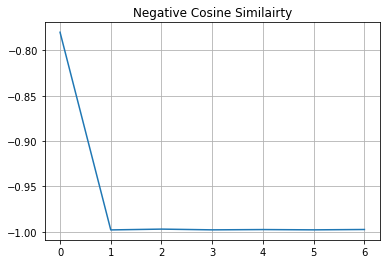

In [77]:
plt.plot(history.history["loss"])
plt.grid()
plt.title("Negative Cosine Similairty")
plt.show()